                    time      tagValue                    tagCode     年   月  \
0    2024-11-17 00:00:00  2.158560e+07  SJ-T-23-1-Efp-0001_AE01_F  2024  11   
1    2024-11-17 00:05:00  2.158640e+07  SJ-T-23-1-Efp-0001_AE01_F  2024  11   
2    2024-11-17 00:10:00  2.158640e+07  SJ-T-23-1-Efp-0001_AE01_F  2024  11   
3    2024-11-17 00:15:00  2.158640e+07  SJ-T-23-1-Efp-0001_AE01_F  2024  11   
4    2024-11-17 00:20:00  2.158640e+07  SJ-T-23-1-Efp-0001_AE01_F  2024  11   
...                  ...           ...                        ...   ...  ..   
7001 2024-11-20 10:55:00  3.455200e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   
7002 2024-11-20 11:00:00  3.455280e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   
7003 2024-11-20 11:05:00  3.455280e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   
7004 2024-11-20 11:10:00  3.455280e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   
7005 2024-11-20 11:15:00  3.455360e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   

       日   时   分  
0     17   0   0  
1     17   0 

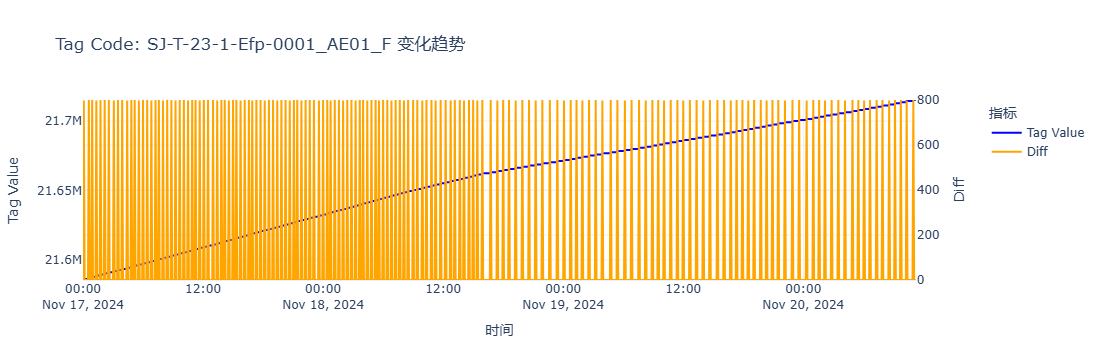

Tag Code: SJ-T-23-1-Efp-0002_AE01_F
                    time      tagValue                    tagCode     年   月  \
1000 2024-11-17 00:00:00  1.907200e+07  SJ-T-23-1-Efp-0002_AE01_F  2024  11   
1001 2024-11-17 00:00:00  1.907200e+07  SJ-T-23-1-Efp-0002_AE01_F  2024  11   
1002 2024-11-17 00:05:00  1.907200e+07  SJ-T-23-1-Efp-0002_AE01_F  2024  11   
1003 2024-11-17 00:10:00  1.907200e+07  SJ-T-23-1-Efp-0002_AE01_F  2024  11   
1004 2024-11-17 00:15:00  1.907280e+07  SJ-T-23-1-Efp-0002_AE01_F  2024  11   
...                  ...           ...                        ...   ...  ..   
1996 2024-11-20 10:55:00  1.920480e+07  SJ-T-23-1-Efp-0002_AE01_F  2024  11   
1997 2024-11-20 11:00:00  1.920480e+07  SJ-T-23-1-Efp-0002_AE01_F  2024  11   
1998 2024-11-20 11:05:00  1.920480e+07  SJ-T-23-1-Efp-0002_AE01_F  2024  11   
1999 2024-11-20 11:10:00  1.920560e+07  SJ-T-23-1-Efp-0002_AE01_F  2024  11   
2000 2024-11-20 11:15:00  1.920560e+07  SJ-T-23-1-Efp-0002_AE01_F  2024  11   

       日   时   

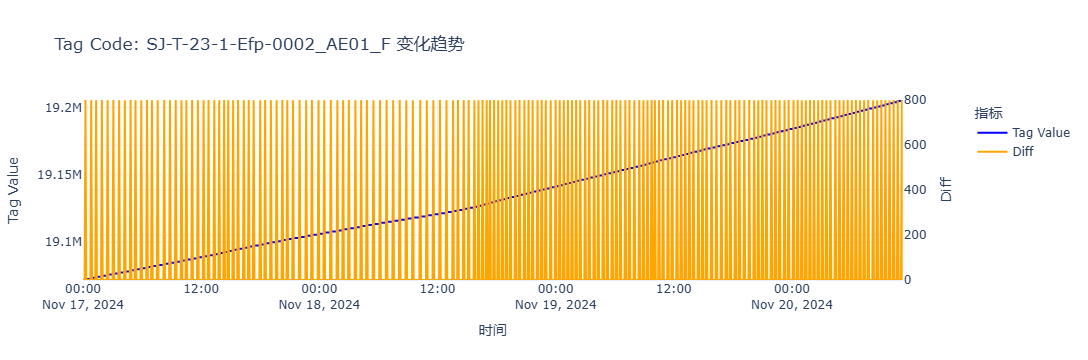

Tag Code: SJ-T-23-1-Efp-0003_AE01_F
                    time      tagValue                    tagCode     年   月  \
2001 2024-11-17 00:00:00  1.882000e+07  SJ-T-23-1-Efp-0003_AE01_F  2024  11   
2002 2024-11-17 00:00:00  1.882000e+07  SJ-T-23-1-Efp-0003_AE01_F  2024  11   
2003 2024-11-17 00:05:00  1.882000e+07  SJ-T-23-1-Efp-0003_AE01_F  2024  11   
2004 2024-11-17 00:10:00  1.882000e+07  SJ-T-23-1-Efp-0003_AE01_F  2024  11   
2005 2024-11-17 00:15:00  1.882000e+07  SJ-T-23-1-Efp-0003_AE01_F  2024  11   
...                  ...           ...                        ...   ...  ..   
2997 2024-11-20 10:55:00  1.892160e+07  SJ-T-23-1-Efp-0003_AE01_F  2024  11   
2998 2024-11-20 11:00:00  1.892160e+07  SJ-T-23-1-Efp-0003_AE01_F  2024  11   
2999 2024-11-20 11:05:00  1.892160e+07  SJ-T-23-1-Efp-0003_AE01_F  2024  11   
3000 2024-11-20 11:10:00  1.892160e+07  SJ-T-23-1-Efp-0003_AE01_F  2024  11   
3001 2024-11-20 11:15:00  1.892160e+07  SJ-T-23-1-Efp-0003_AE01_F  2024  11   

       日   时   

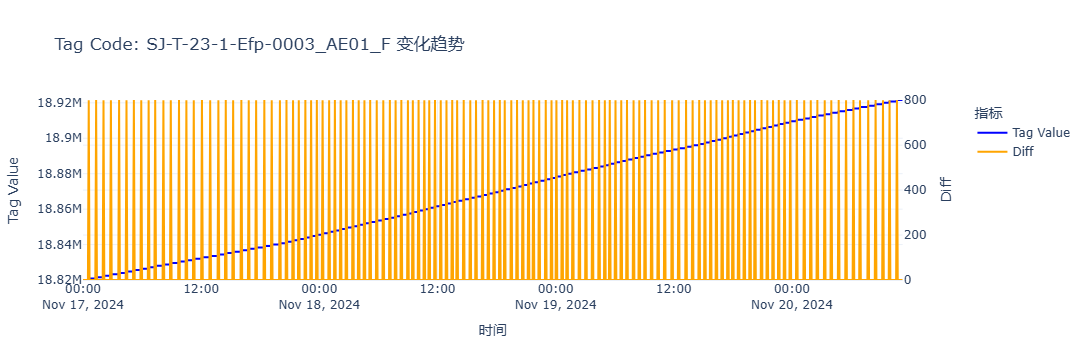

Tag Code: SJ-T-23-1-Efp-0004_AE01_F
                    time      tagValue                    tagCode     年   月  \
3002 2024-11-17 00:00:00  2.265600e+07  SJ-T-23-1-Efp-0004_AE01_F  2024  11   
3003 2024-11-17 00:00:00  2.265600e+07  SJ-T-23-1-Efp-0004_AE01_F  2024  11   
3004 2024-11-17 00:05:00  2.265600e+07  SJ-T-23-1-Efp-0004_AE01_F  2024  11   
3005 2024-11-17 00:10:00  2.265600e+07  SJ-T-23-1-Efp-0004_AE01_F  2024  11   
3006 2024-11-17 00:15:00  2.265600e+07  SJ-T-23-1-Efp-0004_AE01_F  2024  11   
...                  ...           ...                        ...   ...  ..   
3998 2024-11-20 10:55:00  2.282000e+07  SJ-T-23-1-Efp-0004_AE01_F  2024  11   
3999 2024-11-20 11:00:00  2.282000e+07  SJ-T-23-1-Efp-0004_AE01_F  2024  11   
4000 2024-11-20 11:05:00  2.282000e+07  SJ-T-23-1-Efp-0004_AE01_F  2024  11   
4001 2024-11-20 11:10:00  2.282080e+07  SJ-T-23-1-Efp-0004_AE01_F  2024  11   
4002 2024-11-20 11:15:00  2.282080e+07  SJ-T-23-1-Efp-0004_AE01_F  2024  11   

       日   时   

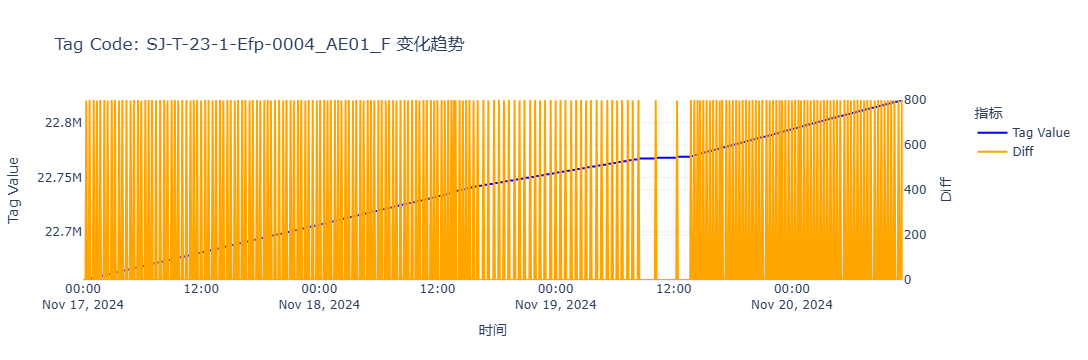

Tag Code: SJ-T-23-1-Efp-0005_AE01_F
                    time      tagValue                    tagCode     年   月  \
4003 2024-11-17 00:00:00  4.257680e+07  SJ-T-23-1-Efp-0005_AE01_F  2024  11   
4004 2024-11-17 00:00:00  4.257680e+07  SJ-T-23-1-Efp-0005_AE01_F  2024  11   
4005 2024-11-17 00:05:00  4.257760e+07  SJ-T-23-1-Efp-0005_AE01_F  2024  11   
4006 2024-11-17 00:10:00  4.257760e+07  SJ-T-23-1-Efp-0005_AE01_F  2024  11   
4007 2024-11-17 00:15:00  4.257760e+07  SJ-T-23-1-Efp-0005_AE01_F  2024  11   
...                  ...           ...                        ...   ...  ..   
4999 2024-11-20 10:55:00  4.284720e+07  SJ-T-23-1-Efp-0005_AE01_F  2024  11   
5000 2024-11-20 11:00:00  4.284720e+07  SJ-T-23-1-Efp-0005_AE01_F  2024  11   
5001 2024-11-20 11:05:00  4.284720e+07  SJ-T-23-1-Efp-0005_AE01_F  2024  11   
5002 2024-11-20 11:10:00  4.284720e+07  SJ-T-23-1-Efp-0005_AE01_F  2024  11   
5003 2024-11-20 11:15:00  4.284800e+07  SJ-T-23-1-Efp-0005_AE01_F  2024  11   

       日   时   

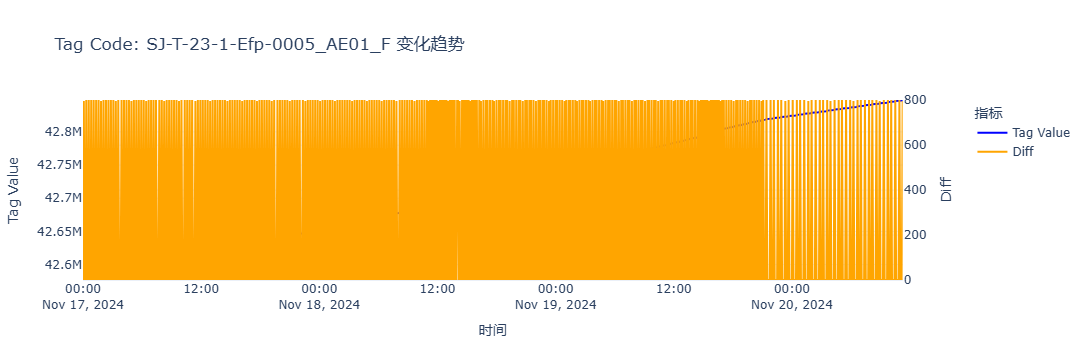

Tag Code: SJ-T-23-1-Efp-0006_AE01_F
                    time      tagValue                    tagCode     年   月  \
5004 2024-11-17 00:00:00  3.591920e+07  SJ-T-23-1-Efp-0006_AE01_F  2024  11   
5005 2024-11-17 00:00:00  3.591920e+07  SJ-T-23-1-Efp-0006_AE01_F  2024  11   
5006 2024-11-17 00:05:00  3.592000e+07  SJ-T-23-1-Efp-0006_AE01_F  2024  11   
5007 2024-11-17 00:10:00  3.592000e+07  SJ-T-23-1-Efp-0006_AE01_F  2024  11   
5008 2024-11-17 00:15:00  3.592080e+07  SJ-T-23-1-Efp-0006_AE01_F  2024  11   
...                  ...           ...                        ...   ...  ..   
6000 2024-11-20 10:55:00  3.624640e+07  SJ-T-23-1-Efp-0006_AE01_F  2024  11   
6001 2024-11-20 11:00:00  3.624640e+07  SJ-T-23-1-Efp-0006_AE01_F  2024  11   
6002 2024-11-20 11:05:00  3.624640e+07  SJ-T-23-1-Efp-0006_AE01_F  2024  11   
6003 2024-11-20 11:10:00  3.624720e+07  SJ-T-23-1-Efp-0006_AE01_F  2024  11   
6004 2024-11-20 11:15:00  3.624720e+07  SJ-T-23-1-Efp-0006_AE01_F  2024  11   

       日   时   

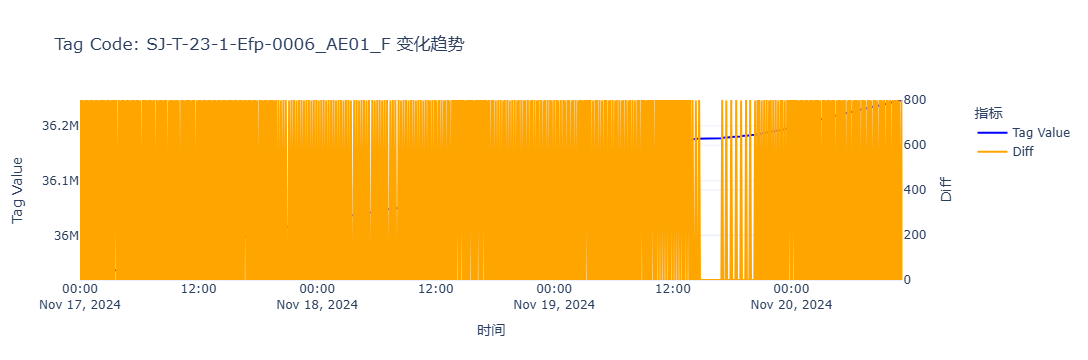

Tag Code: SJ-T-23-1-Efp-0007_AE01_F
                    time      tagValue                    tagCode     年   月  \
6005 2024-11-17 00:00:00  3.426800e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   
6006 2024-11-17 00:00:00  3.426800e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   
6007 2024-11-17 00:05:00  3.426800e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   
6008 2024-11-17 00:10:00  3.426800e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   
6009 2024-11-17 00:15:00  3.426800e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   
...                  ...           ...                        ...   ...  ..   
7001 2024-11-20 10:55:00  3.455200e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   
7002 2024-11-20 11:00:00  3.455280e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   
7003 2024-11-20 11:05:00  3.455280e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   
7004 2024-11-20 11:10:00  3.455280e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   
7005 2024-11-20 11:15:00  3.455360e+07  SJ-T-23-1-Efp-0007_AE01_F  2024  11   

       日   时   

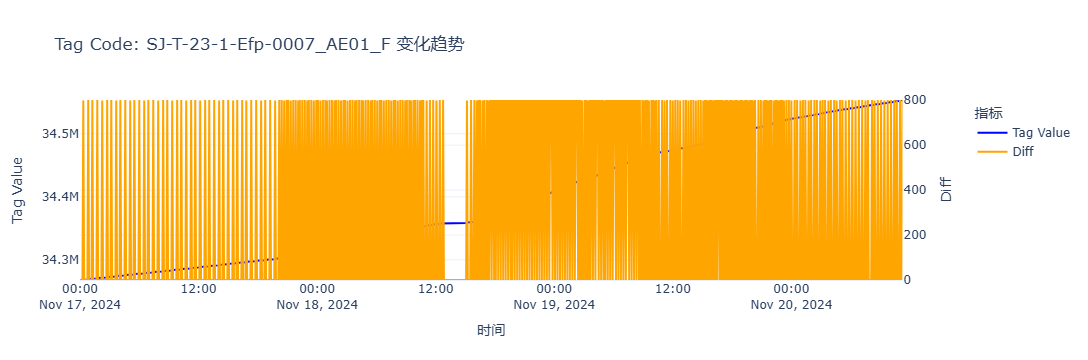

In [1]:
import plotly.express as px
import numpy as np
import pandas as pd
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots  # 导入 make_subplots

# 下面这两行是使用jupyter notebook的时候，用于在notebook中显示图表的设置
import plotly.offline as py
py.init_notebook_mode(connected=True)

# 从.pkl文件读取原始数据
result_df = pd.read_pickle('result_df_electricity.pkl')
print(result_df)

# 获取不重复的tagCode并存储在列表中
tag_codes = result_df['tagCode'].unique().tolist()

# 创建一个ExcelWriter对象
with pd.ExcelWriter('tag_code_analysis.xlsx') as writer:
    # 针对每一个不重复的tagCode，生成一个dataframe，进行处理
    for tag_code in tag_codes:
        # 生成对应tagCode的数据框
        tag_df = result_df[result_df['tagCode'] == tag_code].copy()

        # 读取tagValue，新增一个diff列
        tag_df['diff'] = tag_df['tagValue'].diff().fillna(0).astype(float)

        # 计算z-score、平均值、中位数、标准差
        diff_without_first = tag_df['diff'][1:]
        z_scores = stats.zscore(diff_without_first)

        # 将Z-Score添加到DataFrame中
        tag_df['z_score'] = np.nan
        tag_df.loc[1:, 'z_score'] = z_scores

        mean_diff = np.mean(diff_without_first)
        median_diff = np.median(diff_without_first)
        std_dev_diff = np.std(diff_without_first)

        # 打印输出当前的dataframe及统计结果
        print(f"Tag Code: {tag_code}")
        print(tag_df)
        print(f"平均值: {mean_diff}, 中位数: {median_diff}, 标准差: {std_dev_diff}")
        print("=" * 50)

        # 将当前tag_df写入Excel的对应sheet
        tag_df.to_excel(writer, sheet_name=str(tag_code), index=False)

        # 使用 Plotly 绘制图表
        fig = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])  # 创建单个子图，带有副Y轴

        # 添加 tagValue 曲线到主坐标轴
        fig.add_trace(go.Scatter(x=tag_df['time'], y=tag_df['tagValue'], mode='lines', name='Tag Value',
                                 line=dict(color='blue')), secondary_y=False)

        # 添加 diff 曲线到副坐标轴
        fig.add_trace(go.Scatter(x=tag_df['time'], y=tag_df['diff'], mode='lines', name='Diff',
                                 line=dict(color='orange')), secondary_y=True)

        # 更新布局
        fig.update_layout(
            title=f'Tag Code: {tag_code} 变化趋势',
            xaxis_title='时间',
            legend_title='指标',
            template='plotly_white'
        )

        # 设置主坐标轴和副坐标轴的标题
        fig.update_yaxes(title_text="Tag Value", secondary_y=False)
        fig.update_yaxes(title_text="Diff", secondary_y=True)

        # 设置主坐标轴和副坐标轴的范围
        fig.update_yaxes(range=[tag_df['tagValue'].min(), tag_df['tagValue'].max()], secondary_y=False)
        fig.update_yaxes(range=[tag_df['diff'].min(), tag_df['diff'].max()], secondary_y=True)

        # 显示图表
        fig.show()
        # fig.write_image(f"{tag_code}.png")  # 保存图表为图片